In [124]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
import locale
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('seaborn-notebook')

In [164]:
precio_leche = pd.read_csv('precio_leche.csv')#[mm]
precio_leche.rename(columns = {'Anio': 'anio', 'Mes': 'mes'}, inplace = True) 
precio_leche['mes'] = pd.to_datetime(precio_leche['mes'], format = '%b')
precio_leche['mes'] = precio_leche['mes'].apply(lambda x: x.month)

In [165]:
precipitaciones = pd.read_csv('precipitaciones.csv')
precipitaciones['date'] = pd.to_datetime(precipitaciones['date'], format = '%Y-%m-%d')
precipitaciones[['mes', 'anio']] = precipitaciones['date'].apply(lambda x: pd.Series([x.month, x.year]))

In [166]:
banco_central = pd.read_csv('banco_central.csv')#[mm]
banco_central['Periodo'] = pd.to_datetime(banco_central['Periodo'], infer_datetime_format=True, errors = 'coerce')
banco_central.drop_duplicates(subset = 'Periodo', inplace = True) 
banco_central[['anio', 'mes']] = banco_central['Periodo'].apply(lambda x: pd.Series([x.year, x.month]))

cols_imacec = [x for x in list(banco_central.columns) if 'Imacec' in x] + ['Indice_de_ventas_comercio_real_no_durables_IVCM']
cols_pib = [x for x in list(banco_central.columns) if 'PIB' in x]
banco_central = banco_central[['anio', 'mes'] + cols_pib + cols_imacec]
banco_central = banco_central.dropna()


In [207]:
precio_leche_pp = pd.merge(precio_leche, precipitaciones, on = ['mes', 'anio'], how = 'inner')
precio_leche_pp_pib = pd.merge(precio_leche_pp, banco_central, on = ['mes', 'anio'], how = 'inner')
precio_leche_pp_pib = precio_leche_pp_pib.sort_values(by = ['anio', 'mes'], ascending = True).reset_index(drop=True)

In [208]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class FixingFormattedString(BaseEstimator, TransformerMixin):
    def __init__(self, cols: list, cols_type: str):
        self.cols = cols
        self.cols_type = cols_type

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def casting_finance(self, x):
        if self.cols_type == 'PIB':
            return int(x.replace('.', ''))
        else: 
            x = x.split('.')
            if x[0].startswith('1'): #es 100+
                if len(x[0]) >2:
                    return float(x[0] + '.' + x[1])
                else:
                    x = x[0]+x[1]
                    return float(x[0:3] + '.' + x[3:])
            else:
                if len(x[0])>2:
                    return float(x[0][0:2] + '.' + x[0][-1])
                else:
                    x = x[0] + x[1]
                    return float(x[0:2] + '.' + x[2:])

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.cols:
            if col in X.columns and (X[col].dtypes == 'str' or X[col].dtypes == 'object'):
                X[col] = X[col].apply(lambda x: self.casting_finance(x))
        return X



In [209]:
fx_imacec = FixingFormattedString(cols_imacec, 'IMACEC')
fx_imacec.fit(precio_leche_pp_pib)
precio_leche_pp_pib = fx_imacec.transform(precio_leche_pp_pib)

fx_pib = FixingFormattedString(cols_pib, 'PIB')
fx_pib.fit(precio_leche_pp_pib)
precio_leche_pp_pib = fx_pib.transform(precio_leche_pp_pib)

In [210]:
cc_cols = ['Precio_leche',
 'Coquimbo',
 'Valparaiso',
 'Metropolitana_de_Santiago',
 'Libertador_Gral__Bernardo_O_Higgins',
 'Maule',
 'Biobio',
 'La_Araucania',
 'Los_Rios',
 'PIB_Agropecuario_silvicola',
 'PIB_Pesca',
 'PIB_Mineria',
 'PIB_Mineria_del_cobre',
 'PIB_Otras_actividades_mineras',
 'PIB_Industria_Manufacturera',
 'PIB_Alimentos',
 'PIB_Bebidas_y_tabaco',
 'PIB_Textil',
 'PIB_Maderas_y_muebles',
 'PIB_Celulosa',
 'PIB_Refinacion_de_petroleo',
 'PIB_Quimica',
 'PIB_Minerales_no_metalicos_y_metalica_basica',
 'PIB_Productos_metalicos',
 'PIB_Electricidad',
 'PIB_Construccion',
 'PIB_Comercio',
 'PIB_Restaurantes_y_hoteles',
 'PIB_Transporte',
 'PIB_Comunicaciones',
 'PIB_Servicios_financieros',
 'PIB_Servicios_empresariales',
 'PIB_Servicios_de_vivienda',
 'PIB_Servicios_personales',
 'PIB_Administracion_publica',
 'PIB_a_costo_de_factores',
 'PIB',
 'Imacec_empalmado',
 'Imacec_produccion_de_bienes',
 'Imacec_minero',
 'Imacec_industria',
 'Imacec_resto_de_bienes',
 'Imacec_comercio',
 'Imacec_servicios',
 'Imacec_a_costo_de_factores',
 'Imacec_no_minero',
 'Indice_de_ventas_comercio_real_no_durables_IVCM']

In [211]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.validation import check_is_fitted

class RollingShiftTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols: list, operation: str, window_size: int=3, method: str='mean'):
        self.cols = cols
        self.window_size = window_size
        self.method = method
        self.operation = operation

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()

        if self.operation == 'shift':
            feats = X[self.cols].shift(1)
        elif self.operation == 'rolling':
            if self.method == 'mean':
                feats = X[self.cols].rolling(window=self.window_size, min_periods=1).mean().shift(1)
            elif self.method == 'std':
                feats = X[self.cols].rolling(window=self.window_size, min_periods=1).std().shift(1)
            else:
                raise NotImplementedError
        else:
            raise NotImplementedError

        feats.columns = [f'{x}_{self.operation}{self.window_size}_{self.method}' if self.operation == 'rolling' else f'{x}_{self.operation}' for x in feats.columns]
        
        X = pd.concat([X, feats], axis=1)
        return X

rs_mean = RollingShiftTransformer(cc_cols, 'rolling', 3, 'mean')
rs_std = RollingShiftTransformer(cc_cols, 'rolling', 3, 'std')
rs_s = RollingShiftTransformer(cc_cols, 'shift', 1)

rs_mean.fit(precio_leche_pp_pib)
rs_std.fit(precio_leche_pp_pib)
rs_s.fit(precio_leche_pp_pib)

precio_leche_pp_pib = rs_mean.transform(precio_leche_pp_pib)
precio_leche_pp_pib = rs_std.transform(precio_leche_pp_pib)
precio_leche_pp_pib = rs_s.transform(precio_leche_pp_pib)


In [216]:
precio_leche_pp_pib.dropna().head()

,anio,mes,Precio_leche,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,...,Imacec_empalmado_shift,Imacec_produccion_de_bienes_shift,Imacec_minero_shift,Imacec_industria_shift,Imacec_resto_de_bienes_shift,Imacec_comercio_shift,Imacec_servicios_shift,Imacec_a_costo_de_factores_shift,Imacec_no_minero_shift,Indice_de_ventas_comercio_real_no_durables_IVCM_shift
2,2014,3,227.45,2014-03-01,2.237203,5.082094,5.403087,15.025209,31.280017,78.854388,...,93.500,98.200,94.200,91.800,107.454,102.175,88.800,93.710,93.400,92.800
3,2014,4,232.47,2014-04-01,0.954797,2.044854,11.612500,17.549566,49.346997,91.352068,...,105.885,107.308,101.285,105.167,114.516,117.370,103.080,106.096,106.453,101.583
4,2014,5,244.29,2014-05-01,2.484941,22.233003,59.984144,134.375287,174.540865,196.509109,...,103.133,100.710,97.400,103.903,100.708,106.543,105.138,103.606,103.829,96.300
5,2014,6,243.44,2014-06-01,50.748889,105.865747,116.844044,186.488791,273.414002,360.173444,...,103.643,101.511,106.591,103.056,95.600,103.126,105.888,103.961,103.279,99.800
6,2014,7,238.39,2014-07-01,7.566817,31.821542,65.903742,112.247054,202.997371,346.937354,...,100.806,96.100,103.228,96.600,89.500,94.700,105.880,101.116,100.508,94.600


In [192]:
precio_leche_pp_pib = pd.concat([precio_leche_pp_pib['Precio_leche'], precio_leche_pp_pib_shift3_mean, precio_leche_pp_pib_shift3_std, precio_leche_pp_pib_shift1], axis = 1) 
precio_leche_pp_pib = precio_leche_pp_pib.dropna(how = 'any', axis = 0)
precio_leche_pp_pib.head()

,Precio_leche,Precio_leche_shift3_mean,Coquimbo_shift3_mean,Valparaiso_shift3_mean,Metropolitana_de_Santiago_shift3_mean,Libertador_Gral__Bernardo_O_Higgins_shift3_mean,Maule_shift3_mean,Biobio_shift3_mean,La_Araucania_shift3_mean,Los_Rios_shift3_mean,...,Imacec_empalmado_mes_anterior,Imacec_produccion_de_bienes_mes_anterior,Imacec_minero_mes_anterior,Imacec_industria_mes_anterior,Imacec_resto_de_bienes_mes_anterior,Imacec_comercio_mes_anterior,Imacec_servicios_mes_anterior,Imacec_a_costo_de_factores_mes_anterior,Imacec_no_minero_mes_anterior,Indice_de_ventas_comercio_real_no_durables_IVCM_mes_anterior
2,227.45,216.025000,2.606765,5.384310,12.540671,6.049969,5.423727,27.935100,69.932688,97.720478,...,93.500,98.200,94.200,91.800,107.454,102.175,88.800,93.710,93.400,92.800
3,232.47,219.833333,2.483577,5.283571,10.161477,9.041716,14.042490,44.908196,89.326159,122.554802,...,105.885,107.308,101.285,105.167,114.516,117.370,103.080,106.096,106.453,101.583
4,244.29,226.316667,1.626952,5.172267,11.606219,13.289984,27.880982,64.130884,93.149279,128.269255,...,103.133,100.710,97.400,103.903,100.708,106.543,105.138,103.606,103.829,96.300
5,243.44,234.736667,1.892314,9.786650,25.666577,55.650021,85.055960,122.238522,162.420635,224.370767,...,103.643,101.511,106.591,103.056,95.600,103.126,105.888,103.961,103.279,99.800
6,238.39,240.066667,18.062876,43.381201,62.813563,112.804548,165.767288,216.011540,242.101211,306.731197,...,100.806,96.100,103.228,96.600,89.500,94.700,105.880,101.116,100.508,94.600


In [193]:
precio_leche_pp_pib[['Precio_leche', 'Precio_leche_mes_anterior']]

,Precio_leche,Precio_leche_mes_anterior
2,227.45,219.03
3,232.47,227.45
4,244.29,232.47
5,243.44,244.29
6,238.39,243.44
...,...,...
71,253.86,251.22
72,254.10,253.86
73,270.15,254.10
74,279.88,270.15


In [61]:
i = 999999999

In [33]:
import pandasql as ps

In [35]:
df_result = ps.sqldf("""select * 
                        from banco_central
                        where Periodo is not null""")


,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00.000000,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,None,108.387.837,580.480.672,None,None,None,28577.0
1,2013-04-01 00:00:00.000000,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,None,104.545.429,544.815.032,None,None,None,32206.0
2,2013-05-01 00:00:00.000000,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,None,99.468.801,56.891.916,None,None,None,31589.0
3,2013-06-01 00:00:00.000000,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,None,94.969.678,56.594.867,None,None,None,28457.0
4,2013-07-01 00:00:00.000000,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,None,102.128.977,586.329.899,None,None,None,31736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2008-08-01 00:00:00.000000,792.872.358,809.540.557,844.433.727,862.655.599,721.027.743,640.625.573,829.163.596,799.073.886,786.659.097,...,99.298.129,None,847.665.895,None,905.764.363,475.746.478,None,None,None,NaN
607,2008-09-01 00:00:00.000000,786.802.278,814.228.983,875.931.483,85.990.071,693.602.068,629.581.947,810.645.789,791.396.405,772.867.447,...,972.530.264,None,859.131.907,None,894.789.858,453.055.435,None,None,None,NaN
608,2008-10-01 00:00:00.000000,841.834.519,896.565.998,980.164.017,889.145.021,79.386.738,653.517.611,856.040.952,85.038.187,818.131.883,...,105.609.319,None,902.538.952,None,981.854.401,478.309.081,None,None,None,NaN
609,2008-11-01 00:00:00.000000,82.846.325,845.666.687,864.252.442,83.063.253,843.834.773,638.884.202,881.094.389,838.436.575,825.672.572,...,10.738.286,None,877.968.927,None,914.543.986,466.174.958,None,None,None,NaN


In [ ]:
precipitaciones = pd.read_csv('precipitaciones.csv')#[mm]
precio_leche = pd.read_csv('precio_leche.csv')#[mm]       
precipitaciones['date'] = pd.to_datetime(precipitaciones['date'], format = '%Y-%m-%d')

# banco_central['Periodo'] = banco_central['Periodo'].apply(lambda x: x[0:10])
# banco_central['Periodo'] = pd.to_datetime(banco_central['Periodo'], format = '%Y-%m-%d', errors = 'coerce')



In [29]:
banco_central.shape

(611, 85)

In [ ]:

precio_leche.rename(columns = {'Anio': 'ano', 'Mes': 'mes_pal'}, inplace = True) # precio = nominal, sin iva en clp/litro
precio_leche['mes'] = pd.to_datetime(precio_leche['mes_pal'], format = '%b')
precio_leche['mes'] = precio_leche['mes'].apply(lambda x: x.month)

precipitaciones['mes'] = precipitaciones.date.apply(lambda x: x.month)
precipitaciones['ano'] = precipitaciones.date.apply(lambda x: x.year)

precio_leche_pp = pd.merge(precio_leche, precipitaciones, on = ['mes', 'ano'], how = 'inner')
precio_leche_pp.drop('date', axis = 1, inplace = True)

precipitaciones = precipitaciones.sort_values(by = 'date', ascending = True).reset_index(drop = True)




banco_central.drop_duplicates(subset = 'Periodo', inplace = True)
banco_central = banco_central[~banco_central.Periodo.isna()]


'1.19.2'

In [ ]:
        def convert_int(x):
          return int(x.replace('.', ''))

        cols_pib = [x for x in list(banco_central.columns) if 'PIB' in x]
        cols_pib.extend(['Periodo'])
        banco_central_pib = banco_central[cols_pib]
        banco_central_pib = banco_central_pib.dropna(how = 'any', axis = 0)

        for col in cols_pib:
            if col == 'Periodo':
                continue
            else:
                banco_central_pib[col] = banco_central_pib[col].apply(lambda x: convert_int(x))

        banco_central_pib.sort_values(by = 'Periodo', ascending = True)

        def to_100(x): #mirando datos del bc, pib existe entre ~85-120 - igual esto es cm (?)
            x = x.split('.')
            if x[0].startswith('1'): #es 100+
                if len(x[0]) >2:
                    return float(x[0] + '.' + x[1])
                else:
                    x = x[0]+x[1]
                    return float(x[0:3] + '.' + x[3:])
            else:
                if len(x[0])>2:
                    return float(x[0][0:2] + '.' + x[0][-1])
                else:
                    x = x[0] + x[1]
                    return float(x[0:2] + '.' + x[2:])

                
        cols_imacec = [x for x in list(banco_central.columns) if 'Imacec' in x]
        cols_imacec.extend(['Periodo'])
        banco_central_imacec = banco_central[cols_imacec]
        banco_central_imacec = banco_central_imacec.dropna(how = 'any', axis = 0)

        for col in cols_imacec:
            if col == 'Periodo':
                continue
            else:
                banco_central_imacec[col] = banco_central_imacec[col].apply(lambda x: to_100(x))
                assert(banco_central_imacec[col].max()>100)
                assert(banco_central_imacec[col].min()>30)

        banco_central_imacec.sort_values(by = 'Periodo', ascending = True)
        banco_central_imacec

        banco_central_iv = banco_central[['Indice_de_ventas_comercio_real_no_durables_IVCM', 'Periodo']]
        banco_central_iv = banco_central_iv.dropna() # -unidades? #parte 
        banco_central_iv = banco_central_iv.sort_values(by = 'Periodo', ascending = True)

        banco_central_iv['num'] = banco_central_iv.Indice_de_ventas_comercio_real_no_durables_IVCM.apply(lambda x: to_100(x))
        banco_central_iv

        banco_central_num = pd.merge(banco_central_pib, banco_central_imacec, on = 'Periodo', how = 'inner')
        banco_central_num = pd.merge(banco_central_num, banco_central_iv, on = 'Periodo', how = 'inner')




        banco_central_num['mes'] = banco_central_num['Periodo'].apply(lambda x: x.month)
        banco_central_num['ano'] = banco_central_num['Periodo'].apply(lambda x: x.year)
        precio_leche_pp_pib = pd.merge(precio_leche_pp, banco_central_num, on = ['mes', 'ano'], how = 'inner')
        precio_leche_pp_pib.drop(['Periodo', 'Indice_de_ventas_comercio_real_no_durables_IVCM', 'mes-ano', 'mes_pal'], axis =1, inplace = True)
        precio_leche_pp_pib

        cc_cols = [x for x in precio_leche_pp_pib.columns if x not in ['ano', 'mes']]

        precio_leche_pp_pib_shift3_mean = precio_leche_pp_pib[cc_cols].rolling(window=3, min_periods=1).mean().shift(1)

        precio_leche_pp_pib_shift3_mean.columns = [x+'_shift3_mean' for x in precio_leche_pp_pib_shift3_mean.columns]
                                                        
        precio_leche_pp_pib_shift3_std = precio_leche_pp_pib[cc_cols].rolling(window=3, min_periods=1).std().shift(1)

        precio_leche_pp_pib_shift3_std.columns = [x+'_shift3_std' for x in precio_leche_pp_pib_shift3_std.columns] 

        precio_leche_pp_pib_shift1 = precio_leche_pp_pib[cc_cols].shift(1)

        precio_leche_pp_pib_shift1.columns = [x+'_mes_anterior' for x in precio_leche_pp_pib_shift1.columns]

        precio_leche_pp_pib = pd.concat([precio_leche_pp_pib['Precio_leche'], precio_leche_pp_pib_shift3_mean, precio_leche_pp_pib_shift3_std, precio_leche_pp_pib_shift1], axis = 1) 
        precio_leche_pp_pib = precio_leche_pp_pib.dropna(how = 'any', axis = 0)
        precio_leche_pp_pib.head()

        X = precio_leche_pp_pib.drop(['Precio_leche'], axis = 1)
        y = precio_leche_pp_pib['Precio_leche']

        print('shape X', X.shape)
        print('shape y', y.shape)





# Desafío Spike

Predecir el precio de un insumo básico, como la leche, a partir de variables climatológicas y macroeconómicas.

## Datos y limpieza de datos

### Precipitaciones

In [41]:
precipitaciones = pd.read_csv('./precipitaciones.csv')#[mm]
precipitaciones['date'] = pd.to_datetime(precipitaciones['date'], format = '%Y-%m-%d')
precipitaciones = precipitaciones.sort_values(by = 'date', ascending = True).reset_index(drop = True)
precipitaciones

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
2,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
3,1979-04-01,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
4,1979-05-01,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116
...,...,...,...,...,...,...,...,...,...
491,2019-12-01,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090
492,2020-01-01,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625
493,2020-02-01,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889
494,2020-03-01,0.003451,0.000666,0.000000,0.000000,0.115566,12.462699,28.310937,73.640866


In [42]:
precipitaciones[precipitaciones.isna().any(axis=1)] #no tiene nans

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios


In [43]:
precipitaciones[precipitaciones.duplicated(subset = 'date', keep = False)] #ni repetidos

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios


In [44]:
regiones = ['Coquimbo', 'Valparaiso', 'Metropolitana_de_Santiago',
       'Libertador_Gral__Bernardo_O_Higgins', 'Maule', 'Biobio',
       'La_Araucania', 'Los_Rios']
precipitaciones[regiones].describe() 

,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,16.154691,32.450980,49.666682,72.249805,98.662773,128.113406,151.486456,199.451789
std,32.629286,55.434330,74.361099,101.426112,122.766771,130.056094,126.628503,140.073615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.001170,0.005331,0.748127
25%,0.821521,1.538162,5.297546,5.343992,11.897363,29.356684,52.930343,89.805643
50%,4.071036,9.037825,19.087592,25.995969,45.649888,79.558557,110.570990,159.467940
75%,16.137600,38.409213,63.408364,101.875093,142.230716,184.751307,208.316243,274.594590
max,347.133889,441.048604,524.592667,645.515752,759.177712,702.434707,661.211203,717.735673


In [45]:
precipitaciones.dtypes

date                                   datetime64[ns]
Coquimbo                                      float64
Valparaiso                                    float64
Metropolitana_de_Santiago                     float64
Libertador_Gral__Bernardo_O_Higgins           float64
Maule                                         float64
Biobio                                        float64
La_Araucania                                  float64
Los_Rios                                      float64
dtype: object

#### Observaciones
- Los datos de precipitaciones vienen limpios y completos. 
- Llueve más en el sur que en el norte.

### Banco central

In [46]:
banco_central = pd.read_csv('./banco_central.csv')
banco_central

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2008-08-01 00:00:00 UTC,792.872.358,809.540.557,844.433.727,862.655.599,721.027.743,640.625.573,829.163.596,799.073.886,786.659.097,...,99.298.129,NaN,847.665.895,NaN,905.764.363,475.746.478,NaN,NaN,NaN,NaN
610,2008-09-01 00:00:00 UTC,786.802.278,814.228.983,875.931.483,85.990.071,693.602.068,629.581.947,810.645.789,791.396.405,772.867.447,...,972.530.264,NaN,859.131.907,NaN,894.789.858,453.055.435,NaN,NaN,NaN,NaN
611,2008-10-01 00:00:00 UTC,841.834.519,896.565.998,980.164.017,889.145.021,79.386.738,653.517.611,856.040.952,85.038.187,818.131.883,...,105.609.319,NaN,902.538.952,NaN,981.854.401,478.309.081,NaN,NaN,NaN,NaN
612,2008-11-01 00:00:00 UTC,82.846.325,845.666.687,864.252.442,83.063.253,843.834.773,638.884.202,881.094.389,838.436.575,825.672.572,...,10.738.286,NaN,877.968.927,NaN,914.543.986,466.174.958,NaN,NaN,NaN,NaN


In [47]:
banco_central['Periodo'] = banco_central['Periodo'].apply(lambda x: x[0:10])

banco_central['Periodo'] = pd.to_datetime(banco_central['Periodo'], format = '%Y-%m-%d', errors = 'coerce')
display(banco_central.head())
print(banco_central.columns) 


,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


Index(['Periodo', 'Imacec_empalmado', 'Imacec_produccion_de_bienes',
       'Imacec_minero', 'Imacec_industria', 'Imacec_resto_de_bienes',
       'Imacec_comercio', 'Imacec_servicios', 'Imacec_a_costo_de_factores',
       'Imacec_no_minero', 'PIB_Agropecuario_silvicola', 'PIB_Pesca',
       'PIB_Mineria', 'PIB_Mineria_del_cobre', 'PIB_Otras_actividades_mineras',
       'PIB_Industria_Manufacturera', 'PIB_Alimentos', 'PIB_Bebidas_y_tabaco',
       'PIB_Textil', 'PIB_Maderas_y_muebles', 'PIB_Celulosa',
       'PIB_Refinacion_de_petroleo', 'PIB_Quimica',
       'PIB_Minerales_no_metalicos_y_metalica_basica',
       'PIB_Productos_metalicos', 'PIB_Electricidad', 'PIB_Construccion',
       'PIB_Comercio', 'PIB_Restaurantes_y_hoteles', 'PIB_Transporte',
       'PIB_Comunicaciones', 'PIB_Servicios_financieros',
       'PIB_Servicios_empresariales', 'PIB_Servicios_de_vivienda',
       'PIB_Servicios_personales', 'PIB_Administracion_publica',
       'PIB_a_costo_de_factores', 'Impuesto_al_valor

#### Observaciones
- Datos no vienen como numero, si no, como string con puntos.
- Hay varios datos mezclados: PIB, IMACEC, índices de producción industrial, índice de ventas, etc.. (abajo una gugleada de los términos)
- Fechas no válidas se eliminan. 
- Para poder saber el valor 'real' de los datos, depende de cada una de los grupos de las categorías. Por ejemplo, PIB pareciera ser suficiente convertirlo a entero, mientras que con el IMACEC hay que jugar un poco más (https://www.bcentral.cl/web/banco-central/areas/estadisticas/imacec) -ideal sería preguntarle al cliente la fuente de sus datos, para no estar adivinando valores que pueden o no estar correctos-
- Grupos que pueden ser interesantes, dado el objetivo de predecir $ leche
    - Datos IMACEC fechas: 1996-2020
    - Datos PIB fechas: 2013-2020
    - Indice de ventas bienes no durables (leche) 2014-2020
    - Varios otros: ocupación en areas relacionadas, generación energía eléctrica? (será relevante la electricidad q se usa en la producción de leche?, precios de algunas cosas relacionadas (petroleo/bencina = transporte leches? camiones?)

- IMACEC = El Índice Mensual de Actividad Económica (Imacec) es una estimación que resume la actividad de los distintos sectores de la economía en un determinado mes, a precios del año anterior; **su variación interanual constituye una aproximación de la evolución del PIB**. El cálculo del Imacec se basa en múltiples indicadores de oferta que son ponderados por la participación de las actividades económicas dentro del PIB en el año anterior. -- unidades = , en general se ve la variación del IMACEC de un periodo a otro
- PIB = expresa el valor monetario de la producción de bienes y servicios de demanda final de un país o región durante un período determinado, normalmente de un año o trimestrales. (1960 fue de 4,1 millones de USD - 2019 fue de 282,3 miles de millones USD)
- Derechos de importacion: También denominado derecho aduanero, por tratarse de un impuesto que cobra la aduana de un país para permitir el ingreso de mercancías al territorio nacional.
- Impuesto al valor agregado (IVA)
- Precio de ..
- Tipo de cambio (USD a CLP)
- Ocupados/Ocupacion en ../No responde-no sabe/: Tasa empleo - Encuesta Nacional de Empleo (ENE) ?
- Indices de produccion industrial (x): Es un indicador analítico que tiene por fin mostrar la evolución de la producción física de tres sectores de la economía: Minería, Manufactura y Electricidad, Gas y Agua (EGA). 
- Generacion energia electrica
- Indice de ventas (IVCM = indice ventas comercio al por menor) [$]
 * un bien duradero se define como aquel producto que una vez adquirido puede ser utilizado un gran número de veces a lo largo del tiempo. Los bienes duraderos son aquellos bienes reutilizables y que, aunque pueden acabar gastándose, no se consumen rápidamente como los bienes no duraderos (**leche = no duradero**)
- Venta autos nuevos

In [48]:
banco_central[banco_central.duplicated(subset = 'Periodo', keep = False)] #repetido se elimina

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
65,2018-08-01,109.690.834,994.693.267,101.027.633,1.051.861,931.900.957,106.248.833,117.404.143,109.458.386,110.578.221,...,911.086.301,102.691.109,983.228.221,108.792.744,105.596.535,654.060.172,113.525.936,103.995.337,15.375.472,38729.0
66,2018-08-01,109.690.834,994.693.267,101.027.633,1.051.861,931.900.957,106.248.833,117.404.143,109.458.386,110.578.221,...,911.086.301,102.691.109,983.228.221,108.792.744,105.596.535,654.060.172,113.525.936,103.995.337,15.375.472,38729.0
78,2019-08-01,113.886.371,103.237.519,106.828.407,105.153.122,984.395.274,106.901.816,122.596.004,113.695.907,114.580.893,...,948.715.254,104.034.103,102.619.922,107.666.732,104.591.452,6598,116.203.109,107.385.297,15.342.321,33059.0
79,2019-08-01,113.886.371,103.237.519,106.828.407,105.153.122,984.395.274,106.901.816,122.596.004,113.695.907,114.580.893,...,948.715.254,104.034.103,102.619.922,107.666.732,104.591.452,6598,116.203.109,107.385.297,15.342.321,33059.0


In [49]:
banco_central.drop_duplicates(subset = 'Periodo', inplace = True)
banco_central = banco_central[~banco_central.Periodo.isna()]

In [50]:
def convert_int(x):
    return int(x.replace('.', ''))

cols_pib = [x for x in list(banco_central.columns) if 'PIB' in x]
cols_pib.extend(['Periodo'])
banco_central_pib = banco_central[cols_pib]
banco_central_pib = banco_central_pib.dropna(how = 'any', axis = 0)

for col in cols_pib:
    if col == 'Periodo':
        continue
    else:
        banco_central_pib[col] = banco_central_pib[col].apply(lambda x: convert_int(x))

banco_central_pib.sort_values(by = 'Periodo', ascending = True)
banco_central_pib

,PIB_Agropecuario_silvicola,PIB_Pesca,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Industria_Manufacturera,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Textil,PIB_Maderas_y_muebles,...,PIB_Transporte,PIB_Comunicaciones,PIB_Servicios_financieros,PIB_Servicios_empresariales,PIB_Servicios_de_vivienda,PIB_Servicios_personales,PIB_Administracion_publica,PIB_a_costo_de_factores,PIB,Periodo
0,579846819,570624122,123491343,110356254,131350889,130648285,367818436,162692807,330305467,643366109,...,546694889,337915263,5691837,11393886,793471519,140103913,512994015,108482797,118109613,2013-03-01
1,374895706,606504665,11702736,10358806,134393001,133442735,38211344,188189562,380345362,684106836,...,544306818,348801015,565071466,121229491,80455108,144685333,511803995,107193235,116809697,2013-04-01
2,311356127,545573168,121317874,107784409,135334655,134668498,37345015,184115565,342850811,686925227,...,536681481,355711814,571394036,125792137,805307434,147859706,512469359,107210039,116784548,2013-05-01
3,246592082,418668119,129227656,115404932,138227237,127613384,323857815,17224193,290637238,667221833,...,526589163,353452988,573271479,125565876,811366828,146903407,514736611,105389875,114702694,2013-06-01
4,201156433,565897618,123677441,10915864,145188012,128840589,327206582,163572934,277405414,692167097,...,536446432,353028667,574971364,124038548,813086052,108506835,515375539,101167369,11084055,2013-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,188331918,707214659,1324928,119520525,130720477,123810329,369570934,13719304,164021248,67608185,...,441549174,42522432,715080906,113112652,911758222,116566888,615639916,101614557,111070003,2020-07-01
92,15867781,614712298,130864273,117055913,138696143,125163085,348252328,145265267,181336575,695058355,...,471891836,407014189,711575686,110732905,919298916,140456962,617357193,105754404,116407225,2020-08-01
93,169746171,468872234,126941868,114236494,127906055,12788268,334311036,154593729,206059133,707756582,...,509565911,439254033,720980294,127546136,948454602,131205334,619801512,107849829,118574799,2020-09-01
143,555875498,454921898,120112803,106165654,139471494,127226524,331215957,171180702,310805622,62929711,...,53672742,36993507,571866642,123185498,821085632,762087515,506965418,100532954,109771386,2013-01-01


In [51]:
def to_100(x): #mirando datos del bc, pib existe entre ~85-120 - igual esto es cm (?)
    x = x.split('.')
    if x[0].startswith('1'): #es 100+
        if len(x[0]) >2:
            return float(x[0] + '.' + x[1])
        else:
            x = x[0]+x[1]
            return float(x[0:3] + '.' + x[3:])
    else:
        if len(x[0])>2:
            return float(x[0][0:2] + '.' + x[0][-1])
        else:
            x = x[0] + x[1]
            return float(x[0:2] + '.' + x[2:])

        
cols_imacec = [x for x in list(banco_central.columns) if 'Imacec' in x]
cols_imacec.extend(['Periodo'])
banco_central_imacec = banco_central[cols_imacec]
banco_central_imacec = banco_central_imacec.dropna(how = 'any', axis = 0)

for col in cols_imacec:
    if col == 'Periodo':
        continue
    else:
        banco_central_imacec[col] = banco_central_imacec[col].apply(lambda x: to_100(x))
        assert(banco_central_imacec[col].max()>100)
        assert(banco_central_imacec[col].min()>30)

banco_central_imacec.sort_values(by = 'Periodo', ascending = True)
banco_central_imacec

,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,Periodo
0,102.796,105.46,97.800,102.297,114.994,110.729,100.064,103.163,103.405,2013-03-01
1,101.664,99.90,92.700,104.485,102.199,106.098,102.600,101.937,102.766,2013-04-01
2,101.642,99.30,96.133,105.445,96.800,100.462,104.083,101.953,102.322,2013-05-01
3,99.800,96.80,102.400,99.900,89.190,93.900,103.857,100.222,99.500,2013-06-01
4,96.400,96.10,98.000,100.882,90.100,92.776,96.900,96.200,96.200,2013-07-01
...,...,...,...,...,...,...,...,...,...,...
609,79.200,80.90,84.400,86.200,72.100,64.000,82.900,79.900,78.600,2008-08-01
610,78.600,81.40,87.500,85.990,69.300,62.900,81.000,79.100,77.200,2008-09-01
611,84.100,89.60,98.000,88.900,79.386,65.300,85.600,85.038,81.800,2008-10-01
612,82.846,84.50,86.400,83.063,84.300,63.800,88.100,83.800,82.500,2008-11-01


In [52]:
banco_central_iv = banco_central[['Indice_de_ventas_comercio_real_no_durables_IVCM', 'Periodo']]
banco_central_iv = banco_central_iv.dropna() # -unidades? #parte 
banco_central_iv = banco_central_iv.sort_values(by = 'Periodo', ascending = True)

In [53]:
banco_central_iv.head() #unidades? https://si3.bcentral.cl/siete/ES/Siete/Canasta?idCanasta=M57TP1161519 porcentajes?

,Indice_de_ventas_comercio_real_no_durables_IVCM,Periodo
10,943.909.236,2014-01-01
11,928.126.259,2014-02-01
12,101.583.412,2014-03-01
13,963.546.529,2014-04-01
14,998.625.376,2014-05-01


In [54]:
banco_central_iv['num'] = banco_central_iv.Indice_de_ventas_comercio_real_no_durables_IVCM.apply(lambda x: to_100(x))
banco_central_iv

,Indice_de_ventas_comercio_real_no_durables_IVCM,Periodo,num
10,943.909.236,2014-01-01,94.300
11,928.126.259,2014-02-01,92.800
12,101.583.412,2014-03-01,101.583
13,963.546.529,2014-04-01,96.300
14,998.625.376,2014-05-01,99.800
...,...,...,...
90,824.851.611,2020-06-01,82.400
91,878.226.907,2020-07-01,87.800
92,107.356.493,2020-08-01,107.356
93,107.622.401,2020-09-01,107.622


In [55]:
banco_central_iv.Periodo.min()

Timestamp('2014-01-01 00:00:00')

In [56]:
banco_central_iv.Periodo.max()

Timestamp('2020-10-01 00:00:00')

In [57]:
banco_central_num = pd.merge(banco_central_pib, banco_central_imacec, on = 'Periodo', how = 'inner')
banco_central_num = pd.merge(banco_central_num, banco_central_iv, on = 'Periodo', how = 'inner')

## Visualización

### Funciones

In [58]:
def visualizacion_ppes(df_ppes, region, fecha_i, fecha_f, col_fechas = 'date'):
    '''
    df_ppes = df con datos de preciptaciones
    region = region que se quiere graficar (string)
    fecha_i/fecha_f = fecha inicial y final de periodo a analizar. En un string de formato 'dd-mm-yyyy' 
    col_fechas = columna donde estan las fechas en el df de precipitaciones
    '''
    try:
        df_ppes_region = df_ppes[[col_fechas, region]]
    except:
        print('Región no en datos')
        return np.nan

    try:
        fecha_i = pd.to_datetime(fecha_i, format = '%d-%m-%Y')
        fecha_f = pd.to_datetime(fecha_f, format = '%d-%m-%Y')
        df_ppes_region_fechas = df_ppes_region[(df_ppes_region[col_fechas] >= fecha_i) & (df_ppes_region[col_fechas] <= fecha_f)]
    except:
        print('Revisar fechas')
        return np.nan
        
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(df_ppes_region_fechas[col_fechas], df_ppes_region_fechas[region])
    ax.set_title(f"Precipitaciones en región {' '.join(region.split('_')).title().strip()}")
    ax.set_ylabel('Precipitaciones [mm]')
    ax.set_xlabel('Fecha')

    ax.grid(True)
    plt.show()

def precipitaciones_ano(df_ppes, anos, region, col_fechas = 'date'):
    df_ppes['ano'] = df_ppes[col_fechas].apply(lambda x: x.year)
    df_ppes['mes'] = df_ppes[col_fechas].apply(lambda x: x.strftime("%B"))

    try:
        precipitaciones_region = df_ppes[['ano', 'mes', col_fechas, region]]
    except:
        print('Región no en datos')
        return np.nan
    
    try:
        precipitaciones_region_ano = precipitaciones_region[precipitaciones_region.ano.isin(anos)]
    except:
        print('Revisar lista de años')
        return np.nan

    fig, ax = plt.subplots(figsize = (16,8))
    for ano in anos:
        precipitaciones_ano = precipitaciones_region_ano[precipitaciones_region_ano.ano == ano]
        ax.plot(precipitaciones_ano['mes'], precipitaciones_ano[region], label=ano)
    ax.set_title(f"Precipitaciones en región {' '.join(region.split('_')).title().strip()}")
    ax.set_ylabel('Precipitaciones [mm]')
    ax.set_xlabel('Mes')
    ax.grid(True)
    ax.legend()
    
def series_pib(df, serie1, serie2, fecha_i, fecha_f, col_fecha):
    banco_central_pib_ = df[(df[col_fecha] >= fecha_i) & (df[col_fecha] <= fecha_f)]
    banco_central_pib_serie = banco_central_pib_[[serie1, serie2, col_fecha]]
    banco_central_pib_serie = banco_central_pib_serie.sort_values(by = col_fecha, ascending = True)
    series = [serie1, serie2]
    fig, ax = plt.subplots(figsize = (16,8))
    for serie in series:
        banco_central_pib_selec = banco_central_pib_serie[[serie, 'Periodo']]
        ax.plot(banco_central_pib_selec['Periodo'], banco_central_pib_selec[serie], label=serie.replace('_', ' ').replace('PIB', '').strip())
    ax.set_title(f"PIB entre {fecha_i} y {max(banco_central_pib_selec.Periodo)}")
    ax.set_ylabel('$')
    ax.set_xlabel('Periodo')
    ax.grid(True)
    ax.legend()

### Resultados

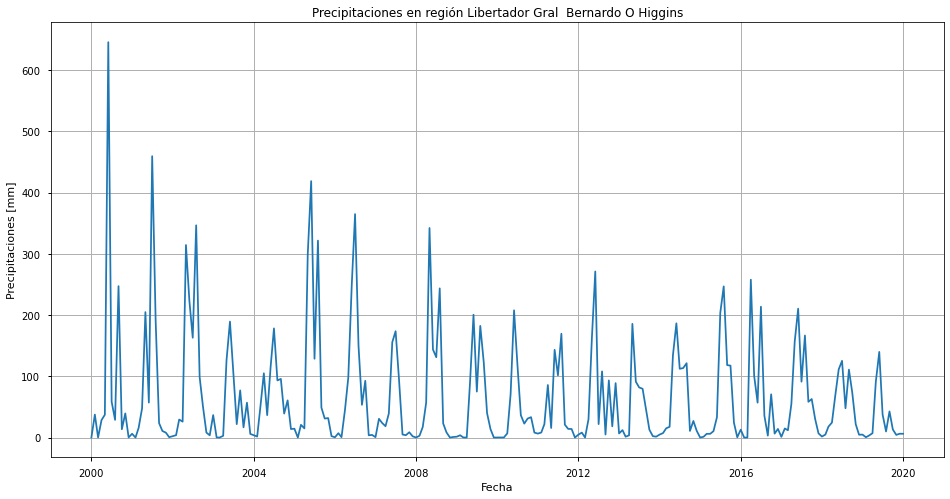

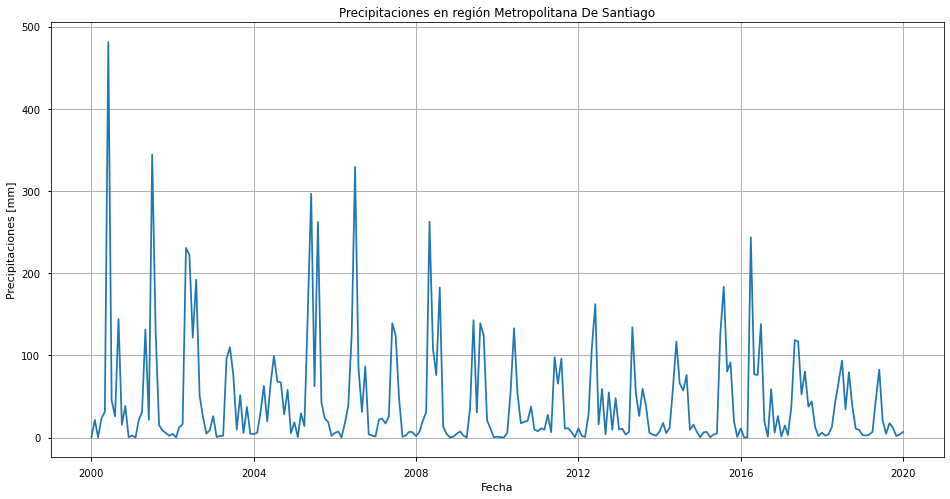

In [59]:
# precipitaciones en Ohiggins vs Metropolitana
fecha_i = '01-01-2000'
fecha_f = '01-01-2020'

visualizacion_ppes(precipitaciones, 'Libertador_Gral__Bernardo_O_Higgins', fecha_i, fecha_f)
visualizacion_ppes(precipitaciones, 'Metropolitana_de_Santiago', fecha_i, fecha_f)

Observaciones
- En general las precipitaciones han disminuido en Chile (</3)
- Región O'Higgins llueve en mayor proporción que en la región Metropolitana
- Ambas regiones tienen la misma estacionalidad de lluvia/no lluvia

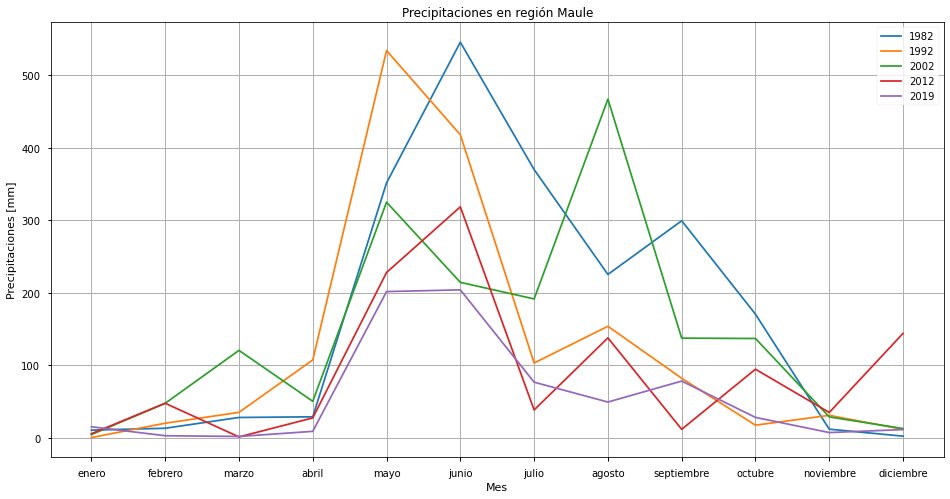

In [60]:
# Precipitaciones para la región del maule durante 1982, 1992, 2002, 2012, 2019
precipitaciones_ano(precipitaciones, [1982, 1992, 2002, 2012, 2019], 'Maule')

Observaciones
- El mes más lluvioso varía entre mayo, junio, julio, agosto (invierno).A medida que pasa el tiempo, el mes más lluvioso se ha ido desplazando desde mayo-junio a junio-julio
- Se observa que  medida que pasa el tiempo, llueve menos en Chile (</3) (volumen total como el maximo de mm/mes)
- La lluvia en Chile ha cambiado con el paso del tiempo y las estaciones no están tan marcadas (esto igual es conocimiento por vivir en Chile jaja). Por ejemplo, el 2002 llovió lo mismo en agosto-octubre y en diciembre(!), mientras que en los años anteriores y los que le siguen, las lluvias en diciembre son bajas (verano). Lo mismo al mirar el 2012, es el único año donde llueve más de 100 mm en abril. En el 2019 el valor máximo no pasa de los 200+ mm.

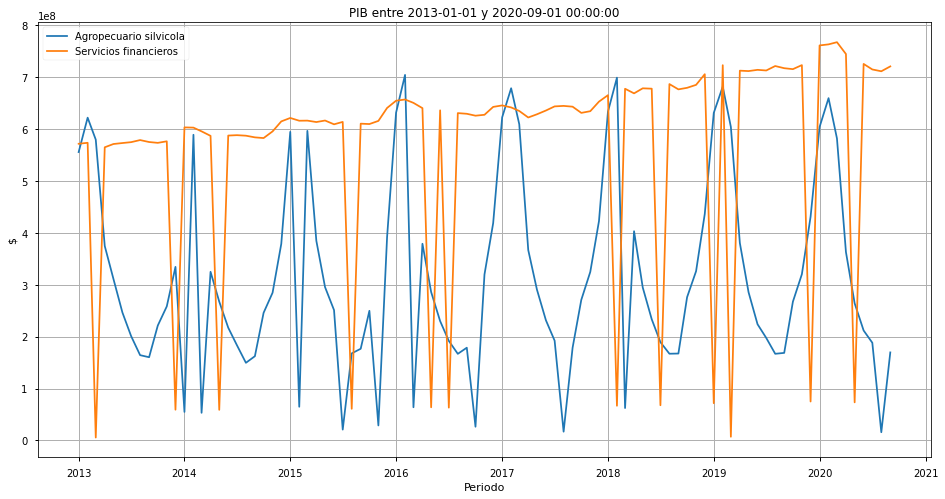

In [61]:
#visualizar dos series hcas de PIB >=2013-01-01
serie1 = 'PIB_Agropecuario_silvicola'
serie2 = 'PIB_Servicios_financieros'
fecha_i = '2013-01-01'
fecha_f = '2021-04-01'
col_fecha = 'Periodo'

series_pib(banco_central_pib, serie1, serie2, fecha_i, fecha_f, col_fecha)


Observaciones
- No sé si las caídas/subidas bruscas corresponden a outliers o si los datos son así (en particular de servicios financieros). Acá sería bueno poder ver la serie mensual para ver los valores (solo he encontrado la serie trimestral/anual) y si fuera el caso, eliminar outliers e interpolar la serie (Tomando como supuesto que sin son outliers, se podría observar que el PIB de servicios financieron ha ido creciendo a lo largo del tiempo)
- Si no son outliers, pareciera ser que el PIB mensual varía bastante entre meses. Quizás por eso se presenta en semestral/trimestral?
- La serie de agropecuario/silvicola tambén varía bastante mes a mes, pero es una variación más suave(?), podría pensarse que cumplen con algún tipo de periodicidad (estaciones del año y productos provenientes de seres vivos?).

## Tratamiento y creación de varaiables

### Variable a predecir: precio leche

In [62]:
precio_leche = pd.read_csv('./precio_leche.csv')
precio_leche.rename(columns = {'Anio': 'ano', 'Mes': 'mes_pal'}, inplace = True) # precio = nominal, sin iva en clp/litro
precio_leche['mes'] = pd.to_datetime(precio_leche['mes_pal'], format = '%b')
precio_leche['mes'] = precio_leche['mes'].apply(lambda x: x.month)
precio_leche['mes-ano'] = precio_leche.apply(lambda x: f'{x.mes}-{x.ano}', axis = 1)
precio_leche.head()

,ano,mes_pal,Precio_leche,mes,mes-ano
0,1979,Ene,3.85,1,1-1979
1,1979,Feb,4.58,2,2-1979
2,1979,Mar,5.18,3,3-1979
3,1979,Abr,6.06,4,4-1979
4,1979,May,7.25,5,5-1979


<AxesSubplot:xlabel='mes-ano'>

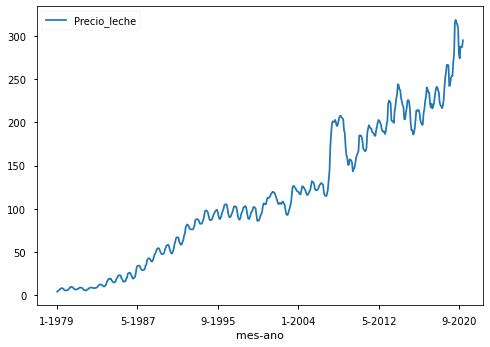

In [63]:
precio_leche.plot(x = 'mes-ano', y = 'Precio_leche') #alza 2010-2011?

<AxesSubplot:xlabel='mes-ano'>

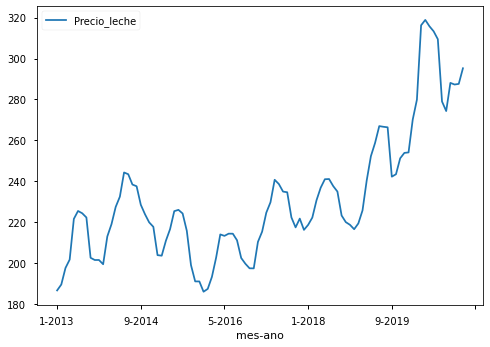

In [64]:
precio_leche[precio_leche.ano>=2013].plot(x = 'mes-ano', y = 'Precio_leche')

In [65]:
precipitaciones['mes'] = precipitaciones.date.apply(lambda x: x.month)
precipitaciones['ano'] = precipitaciones.date.apply(lambda x: x.year)
precio_leche_pp = pd.merge(precio_leche, precipitaciones, on = ['mes', 'ano'], how = 'inner')
precio_leche_pp.drop('date', axis = 1, inplace = True)
precio_leche_pp #precipitaciones fecha_max = 2020-04-01

,ano,mes_pal,Precio_leche,mes,mes-ano,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1979,Ene,3.85,1,1-1979,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447
1,1979,Feb,4.58,2,2-1979,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039
2,1979,Mar,5.18,3,3-1979,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248
3,1979,Abr,6.06,4,4-1979,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127
4,1979,May,7.25,5,5-1979,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,2019,Dic,253.86,12,12-2019,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,62.170090
492,2020,Ene,254.10,1,1-2020,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,63.389625
493,2020,Feb,270.15,2,2-2020,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,55.838889
494,2020,Mar,279.88,3,3-2020,0.003451,0.000666,0.000000,0.000000,0.115566,12.462699,28.310937,73.640866


In [80]:
banco_central_num['mes'] = banco_central_num['Periodo'].apply(lambda x: x.month)
banco_central_num['ano'] = banco_central_num['Periodo'].apply(lambda x: x.year)
precio_leche_pp_pib = pd.merge(precio_leche_pp, banco_central_num, on = ['mes', 'ano'], how = 'inner')
precio_leche_pp_pib.drop(['Periodo', 'Indice_de_ventas_comercio_real_no_durables_IVCM', 'mes-ano', 'mes_pal'], axis =1, inplace = True)
precio_leche_pp_pib

,ano,Precio_leche,mes,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,...,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,num
0,2014,213.02,1,3.524673,2.378766,7.278272,4.804760,7.831522,33.684003,96.707966,...,97.600,101.540,97.700,98.500,107.470,103.244,93.851,97.687,97.500,94.300
1,2014,219.03,2,1.688856,8.389854,17.803070,7.295178,3.015932,22.186197,43.157411,...,93.500,98.200,94.200,91.800,107.454,102.175,88.800,93.710,93.400,92.800
2,2014,227.45,3,2.237203,5.082094,5.403087,15.025209,31.280017,78.854388,128.113100,...,105.885,107.308,101.285,105.167,114.516,117.370,103.080,106.096,106.453,101.583
3,2014,232.47,4,0.954797,2.044854,11.612500,17.549566,49.346997,91.352068,108.177327,...,103.133,100.710,97.400,103.903,100.708,106.543,105.138,103.606,103.829,96.300
4,2014,244.29,5,2.484941,22.233003,59.984144,134.375287,174.540865,196.509109,250.971478,...,103.643,101.511,106.591,103.056,95.600,103.126,105.888,103.961,103.279,99.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2019,253.86,12,0.287895,0.165390,3.601443,6.198806,11.327313,14.014122,27.321858,...,122.347,123.733,113.048,112.460,141.504,136.104,115.830,120.908,123.293,139.938
72,2020,254.10,1,3.299797,2.003685,6.937148,6.154279,7.875591,19.518225,35.916618,...,110.288,110.053,97.100,107.389,122.090,121.522,108.043,110.123,111.698,106.139
73,2020,270.15,2,0.179216,0.003701,0.032064,0.017628,0.200483,10.108504,29.001988,...,106.982,109.066,97.000,101.005,124.713,119.993,102.962,106.934,108.021,107.607
74,2020,279.88,3,0.003451,0.000666,0.000000,0.000000,0.115566,12.462699,28.310937,...,114.025,114.239,102.936,106.375,129.143,121.312,113.370,114.477,115.187,102.108


In [82]:
temp = precio_leche_pp_pib.copy()
temp['anio-mes'] = temp.apply(lambda x: str(x.ano) + '-' + str(x.mes), axis=1)

In [83]:
temp['anio-mes'].value_counts()

2019.0-8.0     1
2018.0-9.0     1
2016.0-2.0     1
2018.0-3.0     1
2018.0-5.0     1
              ..
2015.0-8.0     1
2019.0-9.0     1
2014.0-9.0     1
2015.0-1.0     1
2014.0-11.0    1
Name: anio-mes, Length: 76, dtype: int64

#### Correlación entre variables
Se puede ver la matriz de correlación para observar la correlación entre variables (graficada más abajo). Intuitivamente, una creería que si dos variables están correlacionadas no aportan información distinta y, por lo tanto, convendría tener solo una de ellas..pero yo creo que todo depende de los datos y de que modelo/suposiciones estamos usando. 


<AxesSubplot:>

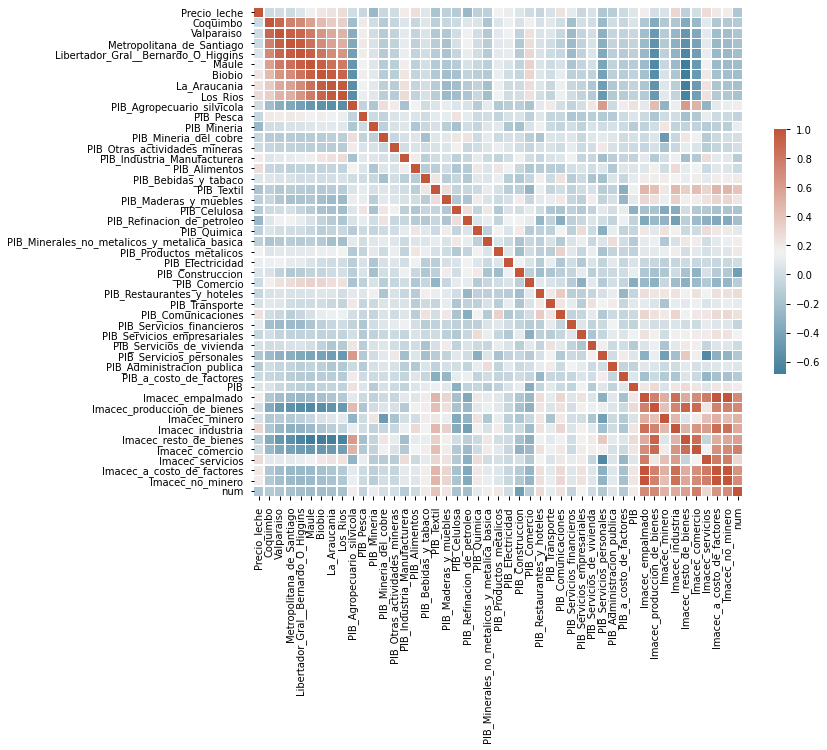

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cc_cols = [x for x in precio_leche_pp_pib.columns if x not in ['ano', 'mes']]
# Compute the correlation matrix
corr = precio_leche_pp_pib[cc_cols].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


- Se observa que las variables de lluvia están correlacionadas entre si y que las variables del imacec + indice de ventas están correlacionadas entre sí. 
- El precio de la leche tiene una correlación levemente positiva con la lluvia en las regiones del sur (tiene sentido dado que allá están las vacas?), pero igual no es muy alta (probablemnte pqe el proceso de la leche está super industrializado), con el PIB de manufactura y de alimentos, PIB del petróleo, PIB de servicios financieros, IMACEC empalmado (la producción de leche es una entrada del IMACEC) y de IMACEC de algunos sectores (servicios, costo de factores y no minero). Sería interesante averiguar más sobre estos indicadores para saber si realmente se relacionan con el precio de la leche.


Con respecto al modelo a usar y la correlación de las variables, se construirán ciertos indicadores para el precio de la leche en el mes n y luego todas esas características serán pasadas a un selector de características. Esto para evitar el sesgo humano de elegir (más pqe yo no tengo experiencia ni conocimiento experto como para elegir las variables correctas)

#### Variables a usar: se eligen las variables relacionadas con el PIB del BC, el IMACEC empalmado, el índice de ventas de comercio real no durable, las precipitaciones y el precio de la leche (n-1) --> Para todas estas se utiliza el indicador del mes anterior y mean/std de 3 meses acumulados

In [68]:
cc_cols = [x for x in precio_leche_pp_pib.columns if x not in ['ano', 'mes']]

In [69]:
precio_leche_pp_pib_shift3_mean = precio_leche_pp_pib[cc_cols].rolling(window=3, min_periods=1).mean().shift(1)

precio_leche_pp_pib_shift3_mean.columns = [x+'_shift3_mean' for x in precio_leche_pp_pib_shift3_mean.columns]
                                                 
precio_leche_pp_pib_shift3_std = precio_leche_pp_pib[cc_cols].rolling(window=3, min_periods=1).std().shift(1)

precio_leche_pp_pib_shift3_std.columns = [x+'_shift3_std' for x in precio_leche_pp_pib_shift3_std.columns] 

precio_leche_pp_pib_shift1 = precio_leche_pp_pib[cc_cols].shift(1)

precio_leche_pp_pib_shift1.columns = [x+'_mes_anterior' for x in precio_leche_pp_pib_shift1.columns]


In [70]:
precio_leche_pp_pib = pd.concat([precio_leche_pp_pib['Precio_leche'], precio_leche_pp_pib_shift3_mean, precio_leche_pp_pib_shift3_std, precio_leche_pp_pib_shift1], axis = 1) 
precio_leche_pp_pib = precio_leche_pp_pib.dropna(how = 'any', axis = 0)
precio_leche_pp_pib.head()

,Precio_leche,Precio_leche_shift3_mean,Coquimbo_shift3_mean,Valparaiso_shift3_mean,Metropolitana_de_Santiago_shift3_mean,Libertador_Gral__Bernardo_O_Higgins_shift3_mean,Maule_shift3_mean,Biobio_shift3_mean,La_Araucania_shift3_mean,Los_Rios_shift3_mean,...,Imacec_empalmado_mes_anterior,Imacec_produccion_de_bienes_mes_anterior,Imacec_minero_mes_anterior,Imacec_industria_mes_anterior,Imacec_resto_de_bienes_mes_anterior,Imacec_comercio_mes_anterior,Imacec_servicios_mes_anterior,Imacec_a_costo_de_factores_mes_anterior,Imacec_no_minero_mes_anterior,num_mes_anterior
2,227.45,216.025000,2.606765,5.384310,12.540671,6.049969,5.423727,27.935100,69.932688,97.720478,...,93.500,98.200,94.200,91.800,107.454,102.175,88.800,93.710,93.400,92.800
3,232.47,219.833333,2.483577,5.283571,10.161477,9.041716,14.042490,44.908196,89.326159,122.554802,...,105.885,107.308,101.285,105.167,114.516,117.370,103.080,106.096,106.453,101.583
4,244.29,226.316667,1.626952,5.172267,11.606219,13.289984,27.880982,64.130884,93.149279,128.269255,...,103.133,100.710,97.400,103.903,100.708,106.543,105.138,103.606,103.829,96.300
5,243.44,234.736667,1.892314,9.786650,25.666577,55.650021,85.055960,122.238522,162.420635,224.370767,...,103.643,101.511,106.591,103.056,95.600,103.126,105.888,103.961,103.279,99.800
6,238.39,240.066667,18.062876,43.381201,62.813563,112.804548,165.767288,216.011540,242.101211,306.731197,...,100.806,96.100,103.228,96.600,89.500,94.700,105.880,101.116,100.508,94.600


In [71]:
precio_leche_pp_pib[['Precio_leche', 'Precio_leche_mes_anterior']]

,Precio_leche,Precio_leche_mes_anterior
2,227.45,219.03
3,232.47,227.45
4,244.29,232.47
5,243.44,244.29
6,238.39,243.44
...,...,...
71,253.86,251.22
72,254.10,253.86
73,270.15,254.10
74,279.88,270.15


## Modelo

- Se elige una separación de 80-20 para el test/train

### Regresión utilizando las variables del precio de la leche de periodos anteriores (y variables climatológicas y macroeconómicas)

In [72]:
X = precio_leche_pp_pib.drop(['Precio_leche'], axis = 1)
y = precio_leche_pp_pib['Precio_leche']

In [73]:
X.shape

(74, 141)

In [74]:
y.mean()

227.17054054054057

In [75]:
y.std()

23.074220561014275

In [76]:
for col in (X.columns):
  print(col)

Precio_leche_shift3_mean
Coquimbo_shift3_mean
Valparaiso_shift3_mean
Metropolitana_de_Santiago_shift3_mean
Libertador_Gral__Bernardo_O_Higgins_shift3_mean
Maule_shift3_mean
Biobio_shift3_mean
La_Araucania_shift3_mean
Los_Rios_shift3_mean
PIB_Agropecuario_silvicola_shift3_mean
PIB_Pesca_shift3_mean
PIB_Mineria_shift3_mean
PIB_Mineria_del_cobre_shift3_mean
PIB_Otras_actividades_mineras_shift3_mean
PIB_Industria_Manufacturera_shift3_mean
PIB_Alimentos_shift3_mean
PIB_Bebidas_y_tabaco_shift3_mean
PIB_Textil_shift3_mean
PIB_Maderas_y_muebles_shift3_mean
PIB_Celulosa_shift3_mean
PIB_Refinacion_de_petroleo_shift3_mean
PIB_Quimica_shift3_mean
PIB_Minerales_no_metalicos_y_metalica_basica_shift3_mean
PIB_Productos_metalicos_shift3_mean
PIB_Electricidad_shift3_mean
PIB_Construccion_shift3_mean
PIB_Comercio_shift3_mean
PIB_Restaurantes_y_hoteles_shift3_mean
PIB_Transporte_shift3_mean
PIB_Comunicaciones_shift3_mean
PIB_Servicios_financieros_shift3_mean
PIB_Servicios_empresariales_shift3_mean
PIB_Se

In [36]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

# generate random data-set
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scale', StandardScaler()),
                 ('selector', SelectKBest(mutual_info_regression)),
                 ('poly', PolynomialFeatures()),
                 ('model', Ridge())])
k=[3, 4, 5, 6, 7, 10]
alpha=[1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
poly = [1, 2, 3, 5, 7]
grid = GridSearchCV(estimator = pipe,
                    param_grid = dict(selector__k=k,
                                      poly__degree=poly,
                                      model__alpha=alpha),
                    cv = 3,
                   scoring = 'r2')
grid.fit(X_train, y_train)
y_predicted = grid.predict(X_test)

# evaluar modelo
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
print('RMSE: ', rmse)
print('R2: ', r2)

KeyboardInterrupt: 

In [54]:
grid.best_params_

{'model__alpha': 0.02, 'poly__degree': 3, 'selector__k': 2}

In [66]:
X_train.columns[grid.best_estimator_.named_steps['selector'].get_support()]

Index(['Precio_leche_shift3_mean', 'PIB_Refinacion_de_petroleo_shift3_mean',
       'Precio_leche_mes_anterior', 'PIB_Administracion_publica_mes_anterior'],
      dtype='object')

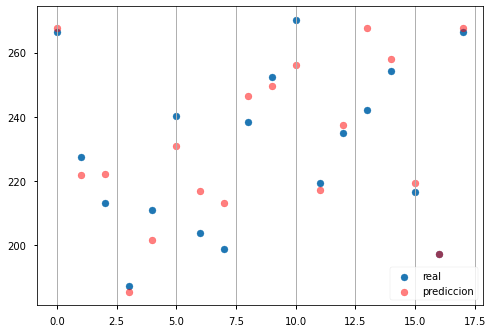

In [127]:
predicted = pd.DataFrame(y_test).reset_index(drop = True)
predicted['predicc'] = y_predicted
predicted= predicted.reset_index()
plt.scatter(predicted.index, predicted['Precio_leche'], label = 'real')
plt.scatter(predicted.index, predicted['predicc'], color = 'red', label = 'prediccion', alpha = 0.5)
plt.grid(axis = 'x')
plt.legend()

Text(0, 0.5, 'Residuo (y_real - y_pred)')

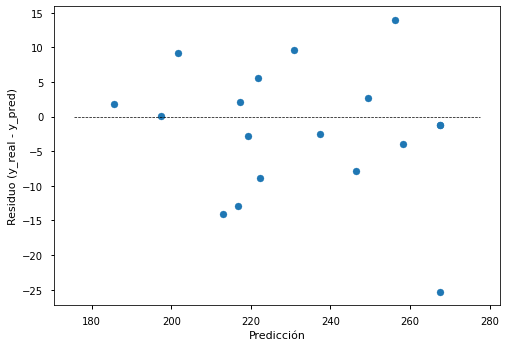

In [128]:
predicted['residual'] = predicted.Precio_leche - predicted.predicc
plt.hlines(0, xmin = predicted.predicc.min()-10, xmax = predicted.predicc.max()+10, linestyle='--', color = 'black', linewidth = 0.7)
plt.scatter(predicted.predicc, predicted.residual)
plt.xlabel('Predicción')
plt.ylabel('Residuo (y_real - y_pred)')

### Regresión utilizando solamente variables macroeconómicas y climatológicas

In [105]:
# generate random data-set
np.random.seed(0)
cols_no_leche = [x for x in list(X.columns) if not ('leche' in x)]
X_train = X_train[cols_no_leche]
X_test = X_test[cols_no_leche]

pipe = Pipeline([('scale', StandardScaler()),
                 ('selector', SelectKBest(mutual_info_regression)),
                 ('poly', PolynomialFeatures()),
                 ('model', Ridge())])
k=[3, 4, 5, 6, 7, 10]
alpha=[1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
poly = [1, 2, 3, 5, 7]
grid = GridSearchCV(estimator = pipe,
                    param_grid = dict(selector__k=k,
                                      poly__degree=poly,
                                      model__alpha=alpha),
                    cv = 3,
                   scoring = 'r2')
grid.fit(X_train, y_train)
y_predicted_noleche = grid.predict(X_test)

# evaluar modelo
rmse = mean_squared_error(y_test, y_predicted_noleche)
r2 = r2_score(y_test, y_predicted_noleche)

# printing values
print('RMSE: ', rmse)
print('R2: ', r2)

RMSE:  389.6857359499568
R2:  0.37103819233050206


In [106]:
grid.best_params_

{'model__alpha': 0.1, 'poly__degree': 1, 'selector__k': 10}

In [108]:
X_train.columns[grid.best_estimator_.named_steps['selector'].get_support()]

Index(['PIB_Refinacion_de_petroleo_shift3_mean',
       'PIB_Productos_metalicos_shift3_mean', 'PIB_Construccion_shift3_mean',
       'PIB_Comunicaciones_shift3_mean',
       'PIB_Administracion_publica_shift3_mean', 'num_shift3_mean',
       'PIB_Refinacion_de_petroleo_mes_anterior',
       'PIB_Comunicaciones_mes_anterior',
       'PIB_Servicios_financieros_mes_anterior',
       'PIB_Administracion_publica_mes_anterior'],
      dtype='object')

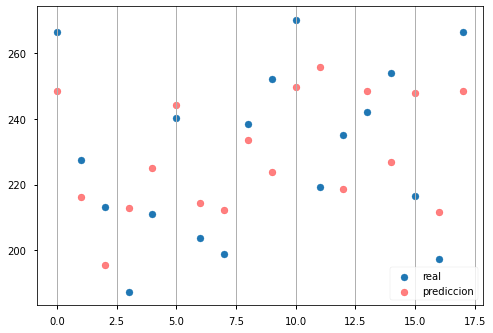

In [129]:
predicted = pd.DataFrame(y_test).reset_index(drop = True)
predicted['predicc'] =y_predicted_noleche
predicted= predicted.reset_index()
plt.scatter(predicted.index, predicted['Precio_leche'], label = 'real')
plt.scatter(predicted.index, predicted['predicc'], color = 'red', label = 'prediccion', alpha = 0.5)
plt.grid(axis = 'x')
plt.legend()

Text(0, 0.5, 'Residuo (y_real - y_pred)')

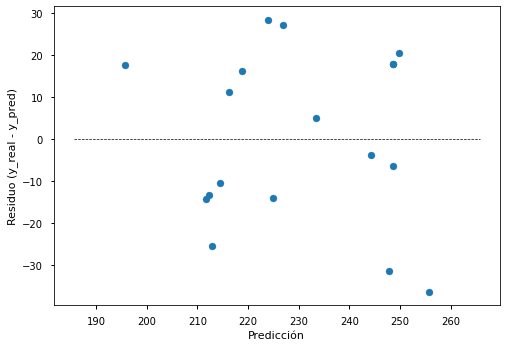

In [130]:
predicted['residual'] = predicted.Precio_leche - predicted.predicc
plt.hlines(0, xmin = predicted.predicc.min()-10, xmax = predicted.predicc.max()+10, linestyle='--', color = 'black', linewidth = 0.7)
plt.scatter(predicted.predicc, predicted.residual)
plt.xlabel('Predicción')
plt.ylabel('Residuo (y_real - y_pred)')

### Observaciones/Respuestas

- Métricas que tiene sentido mirar: creo que tiene sentido mirar el rmse para saber por cuanto se equivoca en promedio las predicciones de los datos reales y el r2 para ver que tal anda la regresión. También tiene sentido ver qué características fueron seleccionadas y su importancia para la predicción, así quizás se puede ir entendiendo más. 

- Al observar las variables seleccionadas en cada una de las regresiones, se observa que en la primera se selecciona: precio leche mes anterior, promedio precio leche 3 meses anteriores, pib precio del petróleo promedio de 3 meses (transporte leches y alimento/insumos para las vacas?) y pib admnistración pública (???). Para el segundo modelo, se observa que se eligen 10 variables: 9 que tienen que ver con el PIB promedio de 3 meses atrás y el valor del mes anterior y el que se relaciona con el promedio de 3 meses del índice de ventas de productos no duraderos (se llama `num`). Llama la atención que el PIB de la zona agropecuaria no está presente en ninguno de los dos (la leche será un % muy bajo?). Las precipitaciones de ninguna región aparecen. En ambas regresiones parece ser relevante el PIB que tiene que ver con el precio del petróleo, lo que tiene sentido dado que -supongo- las leches se transportan desde el sur de Chile hacia la zona centro y norte en camiones.

- Evaluación del modelo: se obtiene una regresión con r2 de 0.85 y rmse de 88.8, utilizando como input el precio de la leche en periodos de tiempo pasado. Esto quizás va un poco en contra del objetivo del problema de 'estimar el precio de un producto usando variables climatológicas y macroeconómicas'. Al sacar estas variables, se observa que baja el r2 (a 0.37) y sube el rmse (a 389.6), por lo que realmente no se estaría logrando el objetivo. Quizás se podría tunear más esta regresión y mejorar un poco los resultados.

- El valor promedio del precio de la leche es de 230.9 con una desviación estándar de 23.68. Claramente el modelo que utiliza precio de leches anteriores tiene un mejor fit que el que no usa, pero creo que determinar si es 'buena' o 'mala' depende del objetivo para el cual se haya construido esta regresión.

- Datos adicionales: 
    - Me gustaría entender más como se pone el precio de la leche en Chile y tener variables de acuerdo a eso. No sé si las precipitaciones influyan tanto, dado que las vacas igual crecen si llueve? Además que no es como que el proceso se vea afectado si es que llueve o por las estaciones del año, google me dice que las vacas tienen un celo con un periodo corto (como las mujeres humanas) y la inseminisación es artificial (para que puedan producir leche), por lo que tiene sentido que las variables relacionadas con las precipitaciones no aparezcan en las regresiones. Quizás tendría sentido tener variables climatológicas que afecten realmente a las vacas (por ejemplo, la comida de las vacas se produce en Chile? Si es así, se vería afectada por alguna razón del clima? Hubo un desastre natural y muchas vacas se murieron?) 
    - No sé mucho de macroeconomiea, pero sería interesante estudiar más las variables del banco central, para agregar otras que puedan influir y para saber si las suposiciones que se realizaron al pasarlas de string a número son correctas o si le metí cualquier valor. También al tener en cuenta el PIB y el IMACEC habría que ver si estos indicadores se ven afectados por la venta de la leche y si la producción es relevante para estos indicadores. Leí un poco y el IMACEC tiene como input (entre varios otros -no sé si esto es lo actual https://si3.bcentral.cl/estadisticas/principal1/metodologias/ccnn/imacec/serieestudios48.pdf [p20-22] -) la producción de leche, pero dice que es solo el 4.2% por lo que quizás usar el IMACEC no es lo ideal, quizás se podría probar con el IMACEC solo de las actividades agropecuarias y agrícolas? O quizás añadir variables más locales que tengan que ver con las vacas (la electricidad que usa una planta lechera es relevante? El agua que toman las vacas? Los medicamentos que les dan? Qué gastos/insumos conlleva la producción de la leche?)

- Me cuesta ver como este modelo ayudaría al calentamiento global la verdad. Quizás mostrando que el precio de la leche va en alza y que conviene cambiarse a algo más amable y no dependiente de vacas? 